# Deep Pensieve™
A Residual Multi-Stage Maximum Mean Discrepancy Variational Resize-Convolution Auto-Encoder with Group Normalization (RMSMMDVRCAECwGN)

## Imports

In [1]:
import time
import json
import random
import numpy as np
import tensorflow as tf

from libs import utils, gif
from libs.group_norm import GroupNormalization

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Flatten, Reshape, Add, Multiply, Activation, Lambda
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.objectives import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint, LambdaCallback

from keras import optimizers
from keras import backend as K

/home/mlacy/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Images

In [2]:
DIRECTORY = 'roadtrip'

SIZE = 256
CHANNELS = 3
FEATURES = SIZE*SIZE*CHANNELS

MODEL_NAME = DIRECTORY+'-'+str(SIZE)

In [3]:
# load images
imgs, xs, ys = utils.load_images(directory=DIRECTORY,rx=SIZE,ry=SIZE)

# normalize pixels
IMGS = imgs/127.5 - 1
FLAT = np.reshape(IMGS,(-1,SIZE*SIZE*CHANNELS))
SAMPLES =  np.random.permutation(FLAT)[:9]
TOTAL_BATCH = IMGS.shape[0]

# print shapes
print("MODEL: ",MODEL_NAME)
print("IMGS: ",IMGS.shape)
print("FLAT: ",FLAT.shape)
print("SAMPLES: ",SAMPLES.shape)

Loading images:	184
MODEL:  roadtrip-256
IMGS:  (184, 256, 256, 3)
FLAT:  (184, 196608)
SAMPLES:  (9, 196608)


## Utility Functions

In [4]:
def conv_gn_act(X,filters=None,kernel=None,stride=None,padding=None,activation=None):
    
    # convolution
    current_layer = Conv2D(filters,kernel,strides=stride,padding=padding,kernel_initializer=INITIALIZER)(X)  
    
    # group normalization
    current_layer = GroupNormalization(groups=filters,axis=-1)(current_layer)
    
    # activation
    current_layer = Activation(activation)(current_layer)
    
    return current_layer

## Maximum Mean Discrepancy 

In [5]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

## Encoder

In [6]:
def encode(x):
    # set current layer
    current_layer = Reshape((SIZE,SIZE,CHANNELS))(x)
    
    # convolutions
    for layer, n_filters in enumerate(FILTERS):

        # convolution + group norm + activation
        if(KERNELS[layer] == 5 and STRIDES[layer] == 1):
            current_layer = conv_gn_act(current_layer,n_filters,3,1,PADDING,ACTIVATION)
            current_layer = conv_gn_act(current_layer,n_filters,3,1,PADDING,ACTIVATION)
        else:
            current_layer = conv_gn_act(current_layer,n_filters,KERNELS[layer],STRIDES[layer],PADDING,ACTIVATION)

        # max pooling
        if(POOLING and KERNELS[layer] > 1):
            current_layer = MaxPooling2D()(current_layer)
    
    # grab the last shape for reconstruction
    shape = current_layer.get_shape().as_list()
    
    # flatten
    flat = Flatten()(current_layer)
    
    # latent vector
    z = Dense(LATENT_DIM)(flat)
    
    return z, (shape[1],shape[2],shape[3])

## Decoder

In [7]:
def decode(z,z_g,shape=None):
    
    # reverse the encoder
    filters = FILTERS[::-1]
    kernels = KERNELS[::-1]
    strides = STRIDES[::-1]

    # inflate
    inflated = shape[0]*shape[1]*shape[2]
    inflate = Dense(inflated)
    current_layer = inflate(z) ; generator = inflate(z_g)
    
    # reshape
    reshape = Reshape(shape)
    current_layer = reshape(current_layer) ; generator = reshape(generator)
    
    # build layers
    for layer, n_filters in enumerate(filters):
        
        # upsample
        if(POOLING and kernels[layer] > 1):
            u = UpSampling2D()
            current_layer = u(current_layer) ; generator = u(generator)

        # convolution
        if(KERNELS[layer] == 5 and STRIDES[layer] == 1):
            c1 = Conv2D(n_filters,3,strides=1,padding=PADDING,kernel_initializer=INITIALIZER)
            b1 = GroupNormalization(groups=n_filters,axis=-1)
            a1 = Activation(ACTIVATION)
            
            current_layer = c1(current_layer) ; generator = c1(generator)
            current_layer = b1(current_layer) ; generator = b1(generator)
            current_layer = a1(current_layer) ; generator = a1(generator)
            
            c2 = Conv2D(n_filters,3,strides=1,padding=PADDING,kernel_initializer=INITIALIZER)
            b2 = GroupNormalization(groups=n_filters,axis=-1)
            a2 = Activation(ACTIVATION)
            
            current_layer = c2(current_layer) ; generator = c2(generator)
            current_layer = b2(current_layer) ; generator = b2(generator)
            current_layer = a2(current_layer) ; generator = a2(generator)
            
        else:
            c = Conv2D(n_filters,kernels[layer],strides=strides[layer],padding=PADDING,kernel_initializer=INITIALIZER)
            b = GroupNormalization(groups=n_filters,axis=-1)
            a = Activation(ACTIVATION)
            
            current_layer = c(current_layer) ; generator = c(generator)
            current_layer = b(current_layer) ; generator = b(generator)
            current_layer = a(current_layer) ; generator = a(generator)
    
    # output convolution + activation
    conv = Conv2D(CHANNELS,1,strides=1,padding=PADDING)
    activation = Activation('tanh')
    
    current_layer = conv(current_layer)       ; generator = conv(generator)
    current_layer = activation(current_layer) ; generator = activation(generator)

    # flatten
    f = Flatten()
    current_layer = f(current_layer) ; generator = f(generator)
    
    return current_layer, generator

## Residual

In [8]:
def residual(x,x_g):
    
    current_layer = x ; generator = x_g

    # shortcuts
    shortcut = current_layer 
    shortcut_g = generator

    # conv 1
    c1 = Conv2D(R_FILTERS,R_KERNELS,strides=R_STRIDES,padding=PADDING,kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)
    
    # activation 1
    a1 = Activation(ACTIVATION)
    current_layer = a1(current_layer) ; generator = a1(generator)

    # conv 2
    c2 = Conv2D(R_FILTERS,R_KERNELS,strides=R_STRIDES,padding=PADDING,kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)

    # residual scaling
    current_layer = Lambda(lambda x: x * .1)(current_layer)
    generator = Lambda(lambda x: x * .1)(generator)

    # fix shortcut shape if mismatch
    if(shortcut.shape[-1] != current_layer.shape[-1]):
        s = Conv2D(R_FILTERS,1,strides=1,padding=PADDING,kernel_initializer=INITIALIZER)
        shortcut = s(current_layer) ; shortcut_g = s(generator)
        
    # merge shortcut
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])

    return current_layer, generator

## Refiner

In [42]:
def refine(x,x_g):
    # reshape
    reshape = Reshape((SIZE,SIZE,CHANNELS))
    current_layer = reshape(x) ; generator = reshape(x_g)
    
    # shortcuts
    shortcut = current_layer ; shortcut_g = generator
    
    # residual layers
    for layer in range(R_LAYERS):
    
        # residual block
        current_layer, generator = residual(current_layer,generator)
    
    # output convolution + activation
    conv = Conv2D(CHANNELS,1,strides=1,padding=PADDING)
    activation = Activation('tanh')
    
    current_layer = conv(current_layer)       ; generator = conv(generator)
    current_layer = activation(current_layer) ; generator = activation(generator)
    
    # merge shortcut
    merge = Add()
#     current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])
    
    return Flatten()(current_layer), Flatten()(generator)

## Callbacks

In [43]:
RECONS = []

def gifit(epoch=None):
    if (epoch % GIF_STEPS == 0):
        print('saving gif ...')
        [i,z,y] = AUTOENCODER.predict_on_batch(SAMPLES)
        img = np.clip(127.5*(i+1).reshape((-1, SIZE, SIZE, CHANNELS)), 0, 255)
        RECONS.append(utils.montage(img).astype(np.uint8))
        
def saveit(epoch=None):
    if (epoch == 0):
        print('saving model ...')
        with open(MODEL_NAME+'-model.json', 'w') as f:
            json.dump(AUTOENCODER.to_json(), f, ensure_ascii=False)
            
    if (epoch % MODEL_STEPS == 0):
        print('saving weights ...')
        AUTOENCODER.save_weights(MODEL_NAME+'-weights.h5')
        
        print('saving encoder ...')
        ENCODER.save(MODEL_NAME+'-encoder.hdf5')
        
        print('saving generator ...')
        GENERATOR.save(MODEL_NAME+'-generator.hdf5')

## Model

In [44]:
# 512px
# FILTERS = [64,80,96,112,96,80,64]
# KERNELS = [5,5,5,5,5,5,5]
# STRIDES = [1,1,1,1,1,1,1]

# 256px
FILTERS = [64,96,128,160,128,64]
KERNELS = [5,5,5,5,5,5]
STRIDES = [1,1,1,1,1,1]

# Residuals
R_LAYERS  = 16
R_FILTERS = 64
R_KERNELS = 3
R_STRIDES = 1
R_SCALING = .1

# Pooling and padding
POOLING = 'max'
PADDING = 'SAME'

# Default initializer and activation
INITIALIZER = 'he_normal'
ACTIVATION  = 'elu'

# Latent dimension size
LATENT_DIM = 1024

## Training

In [45]:
EPOCHS      = 10001
BATCH_SIZE  = 8

MODEL_STEPS = 50
GIF_STEPS   = 50

In [ ]:
# input
X = Input(shape=(FEATURES,))

# latent
Z, shape = encode(X)

# latent loss
epsilon = tf.random_normal(tf.stack([BATCH_SIZE, LATENT_DIM]))
latent_loss = compute_mmd(epsilon, Z)

# generator input
Z_G = Input(shape=(LATENT_DIM,))

# coarse reconstruction
Y, YG = decode(Z,Z_G,shape)
coarse_loss = mean_squared_error(X,Y)

# fine reconstruction
IMG, IMG_G = refine(Y,YG)
fine_loss = mean_absolute_error(X,IMG)

# define autoencoder
AUTOENCODER = Model(inputs=[X], outputs=[IMG,Z,Y])
AUTOENCODER.add_loss(latent_loss)
AUTOENCODER.add_loss(coarse_loss)
AUTOENCODER.add_loss(fine_loss)

# define encoder
ENCODER = Model(inputs=[X], outputs=[Z])

# define generator
GENERATOR = Model(inputs=[Z_G], outputs=[IMG_G])

# define optimizer
ADAM = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True)

# compile models
AUTOENCODER.compile(optimizer=ADAM)
ENCODER.compile(optimizer=ADAM,loss='mse')
GENERATOR.compile(optimizer=ADAM,loss='mse')

# print summary
AUTOENCODER.summary()

# callbacks
giffer = LambdaCallback(on_epoch_end=lambda epoch, logs: gifit(epoch))
saver = LambdaCallback(on_epoch_end=lambda epoch, logs: saveit(epoch))

# fit model
AUTOENCODER.fit(x=FLAT,batch_size=BATCH_SIZE,verbose=1,epochs=EPOCHS,shuffle=True,callbacks=[giffer,saver])

# save animated gif
gif.build_gif(RECONS, saveto=MODEL_NAME+'-final'+ "-"+str(time.time())+'.gif')

print("done")

/home/mlacy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "flatten_31" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "flatten_31" during training.
/home/mlacy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "dense_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_15" during training.
/home/mlacy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Output "flatten_30" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "flatten_30" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 196608)       0                                            
__________________________________________________________________________________________________
reshape_22 (Reshape)            (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_414 (Conv2D)             (None, 256, 256, 64) 1792        reshape_22[0][0]                 
__________________________________________________________________________________________________
group_normalization_170 (GroupN (None, 256, 256, 64) 128         conv2d_414[0][0]                 
__________________________________________________________________________________________________
activation

Epoch 1/10001
184/184 [==============================] - 33s 182ms/step - loss: 1.1062
saving gif ...
saving model ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 2/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.6985
Epoch 3/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.6289
Epoch 4/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.5618
Epoch 5/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.4802
Epoch 6/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.4454
Epoch 7/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.4288
Epoch 8/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.4226
Epoch 9/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.4105
Epoch 10/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.4061
Epoch 11/10001
184/184 [==============

184/184 [==============================] - 20s 111ms/step - loss: 0.2017
Epoch 93/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.2006
Epoch 94/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.2035
Epoch 95/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.2040
Epoch 96/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.2003
Epoch 97/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.1980
Epoch 98/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1989
Epoch 99/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1965
Epoch 100/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1981
Epoch 101/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1984
saving gif ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 102/10001
184/184 [==============================] - 

184/184 [==============================] - 21s 111ms/step - loss: 0.1606
Epoch 183/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1577
Epoch 184/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1567
Epoch 185/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1584
Epoch 186/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1588
Epoch 187/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1581
Epoch 188/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1573
Epoch 189/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1566
Epoch 190/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1560
Epoch 191/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1558
Epoch 192/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1566
Epoch 193/10001
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.1403
Epoch 273/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1402
Epoch 274/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1408
Epoch 275/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1405
Epoch 276/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1394
Epoch 277/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1384
Epoch 278/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1403
Epoch 279/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1396
Epoch 280/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1380
Epoch 281/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1389
Epoch 282/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1384
Epoch 283/10001
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.1233
Epoch 363/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1237
Epoch 364/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1260
Epoch 365/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1270
Epoch 366/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1241
Epoch 367/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1260
Epoch 368/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1275
Epoch 369/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1250
Epoch 370/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1228
Epoch 371/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1222
Epoch 372/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1239
Epoch 373/10001
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.1150
Epoch 453/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1150
Epoch 454/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1133
Epoch 455/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1127
Epoch 456/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1136
Epoch 457/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1150
Epoch 458/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1140
Epoch 459/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1125
Epoch 460/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1123
Epoch 461/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1112
Epoch 462/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1113
Epoch 463/10001
184/184 [============

184/184 [==============================] - 20s 111ms/step - loss: 0.1063
Epoch 544/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1058
Epoch 545/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1056
Epoch 546/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1049
Epoch 547/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1065
Epoch 548/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1084
Epoch 549/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1070
Epoch 550/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1058
Epoch 551/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.1055
saving gif ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 552/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.1049
Epoch 553/10001
184/184 [===========================

184/184 [==============================] - 21s 112ms/step - loss: 0.1003
Epoch 634/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0996
Epoch 635/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0997
Epoch 636/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1001
Epoch 637/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1006
Epoch 638/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1005
Epoch 639/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1003
Epoch 640/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1018
Epoch 641/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1029
Epoch 642/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1016
Epoch 643/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.1004
Epoch 644/10001
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0960
Epoch 724/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0959
Epoch 725/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0954
Epoch 726/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0957
Epoch 727/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0967
Epoch 728/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0962
Epoch 729/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0961
Epoch 730/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0956
Epoch 731/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0966
Epoch 732/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0983
Epoch 733/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0986
Epoch 734/10001
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0941
Epoch 814/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0940
Epoch 815/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0930
Epoch 816/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0920
Epoch 817/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0910
Epoch 818/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0916
Epoch 819/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0914
Epoch 820/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0911
Epoch 821/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0909
Epoch 822/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0904
Epoch 823/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0915
Epoch 824/10001
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0880
Epoch 904/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0880
Epoch 905/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0889
Epoch 906/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0887
Epoch 907/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0881
Epoch 908/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0882
Epoch 909/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0896
Epoch 910/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0886
Epoch 911/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0884
Epoch 912/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0884
Epoch 913/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0886
Epoch 914/10001
184/184 [============

184/184 [==============================] - 21s 112ms/step - loss: 0.0849
Epoch 995/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0852
Epoch 996/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0845
Epoch 997/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0842
Epoch 998/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0839
Epoch 999/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0856
Epoch 1000/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0855
Epoch 1001/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0864
saving gif ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 1002/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0866
Epoch 1003/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0868
Epoch 1004/10001
184/184 [======================

184/184 [==============================] - 21s 112ms/step - loss: 0.0820
Epoch 1084/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0823
Epoch 1085/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0825
Epoch 1086/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0831
Epoch 1087/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0829
Epoch 1088/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0818
Epoch 1089/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0818
Epoch 1090/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0820
Epoch 1091/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0816
Epoch 1092/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0824
Epoch 1093/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0831
Epoch 1094/10001
184/184 [=

184/184 [==============================] - 21s 112ms/step - loss: 0.0783
Epoch 1173/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0791
Epoch 1174/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0804
Epoch 1175/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0805
Epoch 1176/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0800
Epoch 1177/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0802
Epoch 1178/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0803
Epoch 1179/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0809
Epoch 1180/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0815
Epoch 1181/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0813
Epoch 1182/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0805
Epoch 1183/10001
184/184 [=

184/184 [==============================] - 21s 112ms/step - loss: 0.0799
Epoch 1262/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0792
Epoch 1263/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0779
Epoch 1264/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0780
Epoch 1265/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0788
Epoch 1266/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0780
Epoch 1267/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0774
Epoch 1268/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0777
Epoch 1269/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0772
Epoch 1270/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0772
Epoch 1271/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0779
Epoch 1272/10001
184/184 [=

184/184 [==============================] - 21s 112ms/step - loss: 0.0770
saving gif ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 1352/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0770
Epoch 1353/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0773
Epoch 1354/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0765
Epoch 1355/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0769
Epoch 1356/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0775
Epoch 1357/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0780
Epoch 1358/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0762
Epoch 1359/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0759
Epoch 1360/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0754
Epoch 1361/10001
184/184 [=================

184/184 [==============================] - 20s 111ms/step - loss: 0.0759
Epoch 1441/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0752
Epoch 1442/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0766
Epoch 1443/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0768
Epoch 1444/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.0763
Epoch 1445/10001
184/184 [==============================] - 21s 112ms/step - loss: 0.0767
Epoch 1446/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0759
Epoch 1447/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0748
Epoch 1448/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0748
Epoch 1449/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0753
Epoch 1450/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0750
Epoch 1451/10001
184/184 [=

184/184 [==============================] - 20s 111ms/step - loss: 0.0737
Epoch 1530/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0741
Epoch 1531/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0754
Epoch 1532/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0771
Epoch 1533/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0750
Epoch 1534/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0740
Epoch 1535/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0734
Epoch 1536/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.0727
Epoch 1537/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0733
Epoch 1538/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0740
Epoch 1539/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0738
Epoch 1540/10001
184/184 [=

184/184 [==============================] - 20s 111ms/step - loss: 0.0709
Epoch 1619/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0704
Epoch 1620/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0699
Epoch 1621/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0714
Epoch 1622/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0711
Epoch 1623/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0706
Epoch 1624/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0706
Epoch 1625/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0708
Epoch 1626/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0714
Epoch 1627/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0711
Epoch 1628/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0712
Epoch 1629/10001
184/184 [=

184/184 [==============================] - 20s 111ms/step - loss: 0.0722
Epoch 1708/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0712
Epoch 1709/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0714
Epoch 1710/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.0726
Epoch 1711/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0725
Epoch 1712/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0721
Epoch 1713/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0717
Epoch 1714/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0706
Epoch 1715/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0710
Epoch 1716/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0702
Epoch 1717/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0693
Epoch 1718/10001
184/184 [=

184/184 [==============================] - 20s 111ms/step - loss: 0.0690
Epoch 1798/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0691
Epoch 1799/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0693
Epoch 1800/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0688
Epoch 1801/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0682
saving gif ...
saving weights ...
saving encoder ...
saving generator ...
Epoch 1802/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0680
Epoch 1803/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0685
Epoch 1804/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0678
Epoch 1805/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0675
Epoch 1806/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0677
Epoch 1807/10001
184/184 [=================

184/184 [==============================] - 20s 111ms/step - loss: 0.0675
Epoch 1887/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0680
Epoch 1888/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0691
Epoch 1889/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0686
Epoch 1890/10001
184/184 [==============================] - 21s 111ms/step - loss: 0.0677
Epoch 1891/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0695
Epoch 1892/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0692
Epoch 1893/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0693
Epoch 1894/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0691
Epoch 1895/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0685
Epoch 1896/10001
184/184 [==============================] - 20s 111ms/step - loss: 0.0678
Epoch 1897/10001
184/184 [=

## Load Models

In [13]:
print('loading encoder ...')
ENCODER = load_model(MODEL_NAME+'-encoder.hdf5')

print('loading generator ...')
GENERATOR = load_model(MODEL_NAME+'-generator.hdf5')

print('done')

loading encoder ...


/home/mlacy/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


loading generator ...
done


## Reconstruction 

In [14]:
def reconstruct(index=0):
    x = np.reshape(FLAT[index],(-1,FEATURES))
    z = np.reshape(ENCODER.predict_on_batch(x),(-1,LATENT_DIM))
    y = np.reshape(GENERATOR.predict_on_batch(z),(-1,FEATURES))
    
    t = IMGS[index]/2 + .5
    img = np.reshape(y[0]/2 + .5,(SIZE,SIZE,CHANNELS))
    
    print("PSNR: %.3f" % utils.psnr(t,img))
    print("MS-SSIM: %.3f" % utils.MultiScaleSSIM(np.reshape(t,(1,SIZE,SIZE,CHANNELS)),
                                                 np.reshape(img,(1,SIZE,SIZE,CHANNELS)),
                                                 max_val=1.))
    
   
    return t, img

6
PSNR: 28.671


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MS-SSIM: 0.956


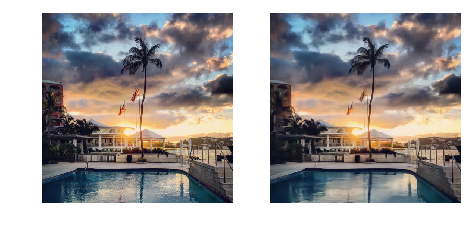

In [24]:
r = random.randint(0,TOTAL_BATCH) ; print(r)
orig, img = reconstruct(r)
utils.showImagesHorizontally(images=[orig,img])

## Latent  Animation

In [51]:
def random_latents(n_imgs=3,path='linear',steps=30,slices=1,directory='roadtrip'):
    imgs = np.random.permutation(FLAT)[:n_imgs]
    latent_animation(imgs,steps,slices,path=path)

def latent_animation(imgs=None,steps=None,slices=None,path=None,filename="latent-animation-"):
    # get encodings
    print('getting latent vectors ...')
    latents = []
    for index,img in enumerate(imgs):
        img = np.reshape(img,(-1,FEATURES))
        latent = ENCODER.predict_on_batch(img)
        latents.append(latent)

    # calculate latent transitions
    print('calculating latent manifold path ...')
    recons = []
    current_step = None
    for i in range(len(latents)-1):
        print("IMG: " + str(i))
        l1 = latents[i]
        l2 = latents[i+1]

        # latent image distance
        image_distance = l2 - l1

        # sine wave for animation steps
        integral = steps*(1+np.cos(np.pi/steps))/np.pi
        normalizer = image_distance/integral

        # start image
        current_step = l1
        
        # build latent vectors to animate transition
#         recons.append(l1)
#         for i in range(steps):
#             if (path == 'contract'):
#                 current_step = current_step + normalizer*np.sin(np.pi*i/steps)
#             else: # linear
#                 current_step = l1 + i*image_distance/steps

#             recons.append(current_step)
#         recons.append(l2)
        
        recons.append(l1)
        for i in range(steps):
            current_step = l1 + i*image_distance/steps
            recons.append(current_step)
            
            if(i > 1 and (i+1) % int(steps/slices) == 0):
                print('reconstructing ... ',i)
                recons = np.reshape(recons,(-1,LATENT_DIM))
                i = GENERATOR.predict_on_batch(recons)

                # de-normalize and clip the output
                final = np.clip((127.5*(i+1)).reshape((-1,SIZE,SIZE,CHANNELS)),0,255)

                # build the gif
                filename = filename+str(time.time())
                gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+"-final.gif",dpi=SIZE)

                print(filename)
                
                recons = []
                filename="latent-animation-"
        recons.append(l2)
                
#         recons.append(l2)
    
    # get predictions from latent vectors
    print('reconstructing ... ')
    recons = np.reshape(recons,(-1,LATENT_DIM))
    i = GENERATOR.predict_on_batch(recons)

    # de-normalize and clip the output
    final = np.clip((127.5*(i+1)).reshape((-1,SIZE,SIZE,CHANNELS)),0,255)

    # build the gif
    filename = filename+str(time.time())
    gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+"-final.gif",dpi=SIZE)

    print(filename)


getting latent vectors ...
calculating latent manifold path ...
IMG: 0
reconstructing ...  39
latent-animation-1526139070.6597452
reconstructing ...  79
latent-animation-1526139095.9274144
reconstructing ...  119
latent-animation-1526139119.0635438
reconstructing ...  159
latent-animation-1526139140.5486512
IMG: 1
reconstructing ...  39
latent-animation-1526139159.8836818
reconstructing ...  79
latent-animation-1526139179.7467513
reconstructing ...  119
latent-animation-1526139200.5845547
reconstructing ...  159
latent-animation-1526139222.2305057
reconstructing ... 
latent-animation-1526139238.5314615


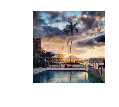

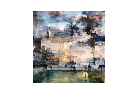

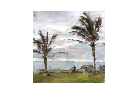

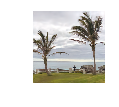

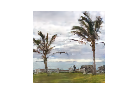

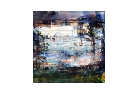

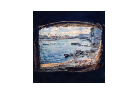

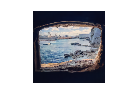

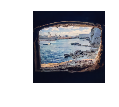

In [58]:
random_latents(n_imgs=3,steps=160,slices=4)

0
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991365.8722703
1
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991388.8541355
2
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991412.1551075
3
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991437.1593966
4
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991460.450388
5
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991482.1681547
6
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991504.9546645
7
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 
latent-animation-1525991528.7147522
8
getting latent vectors 

/home/mlacy/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


latent-animation-1525991837.386685
21
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 


/home/mlacy/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


latent-animation-1525991860.8616886
22
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 


/home/mlacy/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


latent-animation-1525991883.569883
23
getting latent vectors ...
calculating latent manifold path ...
reconstructing ... 


/home/mlacy/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


latent-animation-1525991908.3093839
24


IndexError: index 25 is out of bounds for axis 0 with size 25

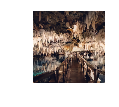

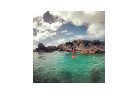

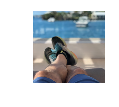

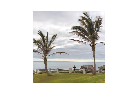

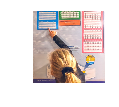

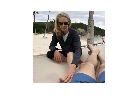

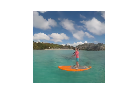

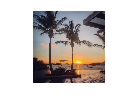

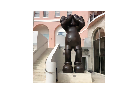

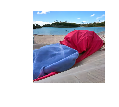

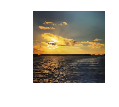

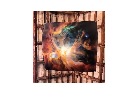

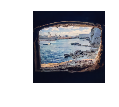

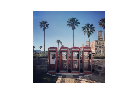

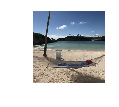

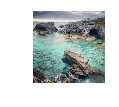

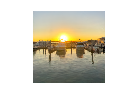

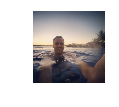

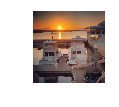

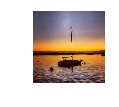

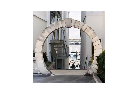

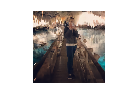

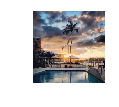

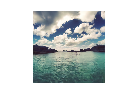

In [44]:
imgs =  np.random.permutation(FLAT)
for i in range(TOTAL_BATCH):
    print(i)
    latent_animation([imgs[i],imgs[i+1]],40)
    